In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
train_size = 0.9
lr = 1e-3
eps = 1e-8
batch_size = 512
epochs = 30

Dataset

In [5]:
def mnist(train_part, transform=None):
    dataset = torchvision.datasets.MNIST('.', download=True, transform=transform)
    train_part = int(train_part * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])
    return train_dataset, test_dataset

In [6]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset, test_dataset = mnist(train_size, transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloaders = (train_dataloader, test_dataloader)

100%|██████████| 9912422/9912422 [00:00<00:00, 190584883.86it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 44274741.89it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 71186299.78it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 10101022.68it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Conditional VAE model

In [7]:
class VAEEncoder(nn.Module):
    def __init__(self):
        super(VAEEncoder, self).__init__()
        self.num_classes = 10
        self.latent_dim = 2
        self.conv1 = nn.Conv2d(1 + self.num_classes , 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.z_mean = nn.Linear(64*7*7, self.latent_dim)
        self.z_log = nn.Linear(64*7*7, self.latent_dim)
        self.relu = nn.ReLU()
    

    def forward(self, input, labels):
        bs = input.shape[0]
        
        def to_onehot(labels, num_classes,device):
            labels_onehot = torch.zeros(labels.size()[0], num_classes).to(device)
            labels_onehot.scatter_(1, labels.view(-1, 1), 1)
            return labels_onehot

        onehot = to_onehot(labels, self.num_classes, input.device)
        onehot = onehot.view(-1, self.num_classes, 1, 1)

        ones = torch.ones((bs, self.num_classes, input.shape[2], input.shape[3]), dtype=input.dtype).to(input.device)
        ones = ones * onehot 
        x = torch.cat((input, ones), dim=1)

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        z_mean = self.z_mean(x)
        z_log = self.z_log(x)

        eps = torch.randn(bs, self.latent_dim, device=input.device)
        z_val = z_mean + torch.exp(z_log / 2) * eps
        return z_mean, z_log, z_val
    


class VAEDecoder(nn.Module):
    def __init__(self):
        super(VAEDecoder, self).__init__()
        self.num_classes = 10
        self.latent_dim = 2
        self.fc1 = nn.Linear(self.latent_dim + self.num_classes, 64*7*7)
        self.reshape = nn.Unflatten(1, (64, 7, 7))
        self.conv1 = nn.ConvTranspose2d(64, 64, 3, stride=2)
        self.conv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(32, 1, 2, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, input, labels):
        
        def to_onehot(labels, num_classes,device):
            labels_onehot = torch.zeros(labels.size()[0], num_classes).to(device)
            labels_onehot.scatter_(1, labels.view(-1, 1), 1)
            return labels_onehot
    
        onehot = to_onehot(labels, self.num_classes, input.device)
        input = torch.cat((input, onehot), dim=1)
        
        x = self.relu(self.fc1(input))
        x = self.reshape(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        decoded = self.sigmoid(self.conv3(x))
        return decoded
    



class VAEAutoEncoder(nn.Module):
        
    def __init__(self):
        super(VAEAutoEncoder, self).__init__()
        self.encoder = VAEEncoder()
        self.decoder = VAEDecoder()

    def forward(self, input, labels):
        z_mean, z_log, z_val = self.encoder(input, labels)
        decoded = self.decoder(z_val, labels)
        return decoded, z_mean, z_log, z_val

In [8]:
model = VAEAutoEncoder()

if torch.cuda.device_count() > 1:
    print(f"using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

using 2 GPUs


DataParallel(
  (module): VAEAutoEncoder(
    (encoder): VAEEncoder(
      (conv1): Conv2d(11, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (z_mean): Linear(in_features=3136, out_features=2, bias=True)
      (z_log): Linear(in_features=3136, out_features=2, bias=True)
      (relu): ReLU()
    )
    (decoder): VAEDecoder(
      (fc1): Linear(in_features=12, out_features=3136, bias=True)
      (reshape): Unflatten(dim=1, unflattened_size=(64, 7, 7))
      (conv1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
      (conv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv3): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (sigmoid): Sigmoid()
    )
  )
)

**Loss Function** -> reconstruction loss + kl divergence

In [9]:
def vae_loss(preds, targets, z_mean, z_log, z_val):
    mse = nn.MSELoss()
    reconstruction_loss = mse(preds.view(preds.shape[0], -1), targets.view(targets.shape[0], -1)) * 784.0
    temp = 1.0 + z_log - torch.square(z_mean) - torch.exp(z_log)
    kl_loss = -0.5 * torch.sum(temp, axis=-1)
    return torch.mean(reconstruction_loss + kl_loss)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)

In [11]:
def train_vae(dataloaders, model, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]
    epoch_train_losses = []

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch  # providing labels as well as compared to normal vaes
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            preds,z_mean, z_log, z_val = model(imgs,labels)
            #print(preds.shape)
            #print(z_val.shape)
            loss = vae_loss(preds, imgs, z_mean, z_log, z_val)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.to(device)
                labels = labels.to(device)

                preds,z_mean, z_log, z_val = model(imgs,labels)
                
                loss = vae_loss(preds, imgs, z_mean, z_log, z_val)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)
        
        epoch_train_losses.append(train_loss)

        tqdm_dct = {'train loss': train_loss, 'test loss': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()
        
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, epochs + 1), epoch_train_losses, label='Train Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

100%|██████████| 30/30 [15:12<00:00, 30.40s/it, train loss=29.4, test loss=29.9]


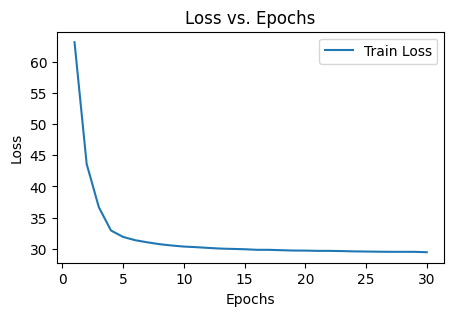

In [12]:
train_vae(dataloaders, model, optimizer, epochs, device)

Generating output and visualizing the results

In [13]:
def plotn(n, data):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(data):
        if i == n:
            break
        preprocess = z[0].reshape(1, 28, 28)
        ax[i].imshow(preprocess[0],cmap ='gray')
        ax[i].axis('off')
    plt.show()

torch.Size([1, 1, 28, 28])
torch.Size([1, 2])
torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 2])
torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 2])
torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 2])
torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 2])
torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 2])
torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 2])
torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 2])
torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 2])
torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 2])
torch.Size([1, 28, 28])


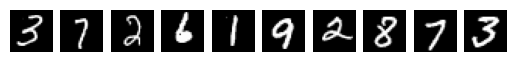

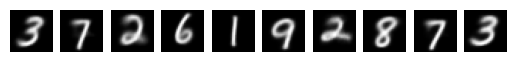

In [14]:
model.eval()
predictions = []
plots = 10
for i, data in enumerate(test_dataset):
    if i == plots:
        break
        
    label_tensor = torch.tensor(data[1]).unsqueeze(0)
    #print(label_tensor)
    output_imgs = model(data[0].to(device).unsqueeze(0),label_tensor)
    print(output_imgs[0].shape)
    print(output_imgs[3].shape)
    op_img = output_imgs[0].view(1, 28, 28)
    print(op_img.shape)
    predictions.append(op_img.detach().cpu())
plotn(plots, test_dataset)
plotn(plots, predictions)

# Latent space visualization of Conditional VAE

6000
6000
6000


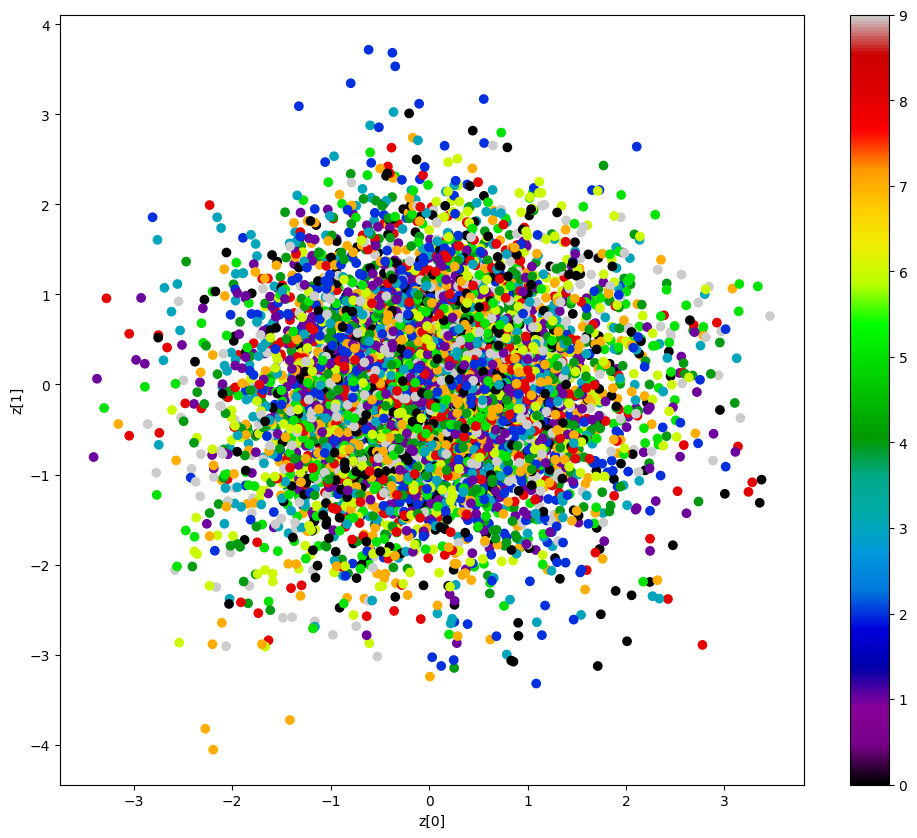

In [15]:
z_mean0 = []
z_mean1 = []
c = []
for x, y in test_dataset:
    lab = torch.tensor(y).unsqueeze(0)
    output_imgs = model(x.to(device).unsqueeze(0),lab)
    z_mean = output_imgs[1].detach().cpu().numpy()
    z_mean0.append(z_mean[0][0])
    z_mean1.append(z_mean[0][1])
    c.append(y)  
print(len(z_mean0))
print(len(z_mean1))
print(len(c))

plt.figure(figsize=(12, 10))
plt.scatter(z_mean0, z_mean1, c=c , cmap = 'nipy_spectral')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")

save_dir = "/kaggle/working/"
filename = "scatter_plot_cond_vae.jpg"
filepath = os.path.join(save_dir, filename)
plt.savefig(filepath)

plt.show()

# Sampling from the latent space, conditioned upon the class obiviously

Example: Sampling the **digit 2** from various areas of latent space and plotting the results

In [16]:
def sample_cord(x1,x2):
    oy = torch.tensor([x1,x2]).unsqueeze(0)
    labes = torch.tensor(2).unsqueeze(0)
    chek = model.module.decoder(oy.to(device),labes.to(device))
    chek = chek.view(1, 28, 28)
    chek = chek.detach().cpu()
    fig, ax = plt.subplots(1, 1,figsize=(3, 3))
    ax.imshow(chek[0],cmap ='gray')
    ax.axis('off')
    #ax.set_title('Digit')
    plt.show
    None

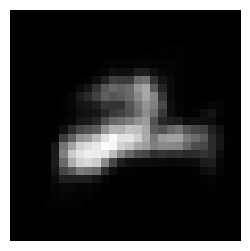

In [17]:
sample_cord(2.5,2.5)

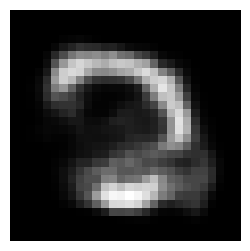

In [18]:
sample_cord(-2.5,-2.5)

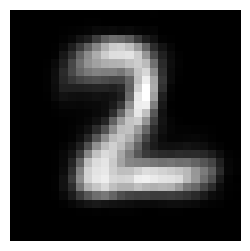

In [19]:
sample_cord(-0.8,1)

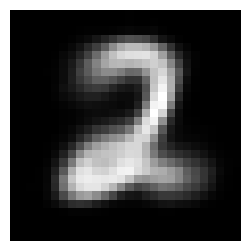

In [20]:
sample_cord(0,0)

Sampling from the latent space conditionally from all digits 0 to 9

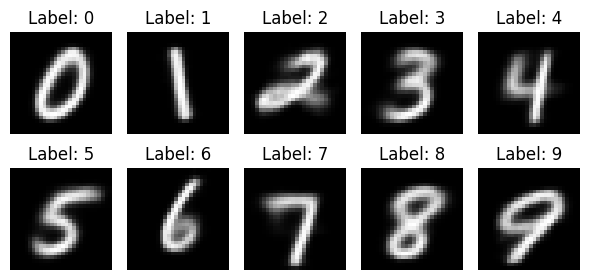

In [21]:
fig, axs = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    rand = torch.randn(1, 2).to(device)
    labels = torch.tensor(i).unsqueeze(0).to(device)
    chek = model.module.decoder(rand, labels)  
    chek = chek.view(1, 28, 28)
    chek = chek.detach().cpu()
    row = i // 5
    col = i % 5
    axs[row, col].imshow(chek[0], cmap='gray')
    axs[row, col].axis('off')
    axs[row, col].set_title(f'Label: {i}')
plt.tight_layout()  
plt.show()